In [1]:
import torch
%matplotlib inline

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import os
import sys
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm

from ast import literal_eval

""
sns.set_context("notebook", font_scale=1.5)
plt.rcParams['figure.figsize'] = (17, 5)

import platform
if 'Windows' in platform.platform():
    ROOT_PATH = "D:/PycharmProjects/HMAN"
else:
    ROOT_PATH = "/home/xkliu/PycharmProjects/HMAN"
RAW_DATA_PATH = ROOT_PATH  + "/raw_data"
DATA_PATH = ROOT_PATH + "/data"
os.chdir(ROOT_PATH)
sys.path.append("./")

from kddirkit.utils import utils


In [2]:
import logging
import torch.nn as nn
import numpy as np

from kddirkit.networks.encoders import SentenceEncoder
from kddirkit.networks.models import BaselineModel
from kddirkit.config import *
# from kddirkit.dataloaders import LoadNYT, LoadHierData
from kddirkit.frameworks import Trainer
from kddirkit.losses.FocalLoss import FocalLoss

project_name = 'HMAN'

logger = logging.getLogger(project_name)

## 1. Load Data

In [3]:
track_dtype = {'track_id': int, 'album_id': int, 'album_type': str, 'artist_id': int, 'set_split': str,
               'set_subset': str, 'track_genre_top': str, 'track_genres': str, 'track_genres_all': str,
               'track_title': str}
genres_converters = {'track_genres': literal_eval, 'track_genres_all': literal_eval}
medium_data = pd.read_csv(RAW_DATA_PATH + '/medium_data.csv', converters=genres_converters)

In [4]:
medium_data_train = pd.read_csv(RAW_DATA_PATH + '/medium_data_train.csv', converters=genres_converters)
medium_data_test = pd.read_csv(RAW_DATA_PATH + '/medium_data_test.csv', converters=genres_converters)
medium_data_val = pd.read_csv(RAW_DATA_PATH + '/medium_data_val.csv', converters=genres_converters)

In [5]:
medium_instance_triple = np.load(DATA_PATH + '/' + 'medium_instance_triple.npy')
medium_instance_scope = np.load(DATA_PATH + '/' + 'medium_instance_scope.npy')
medium_label = np.load(DATA_PATH + '/' + 'medium_label.npy')

In [6]:
medium_train_instance_triple = np.load(DATA_PATH + '/' + 'medium_train_instance_triple.npy')
medium_train_instance_scope = np.load(DATA_PATH + '/' + 'medium_train_instance_scope.npy')
medium_train_label = np.load(DATA_PATH + '/' + 'medium_train_label.npy')

In [7]:
medium_val_instance_triple = np.load(DATA_PATH + '/' + 'medium_val_instance_triple.npy')
medium_val_instance_scope = np.load(DATA_PATH + '/' + 'medium_val_instance_scope.npy')
medium_val_label = np.load(DATA_PATH + '/' + 'medium_val_label.npy')

In [8]:
medium_test_entity_pair = np.load(DATA_PATH + '/' + 'medium_test_entity_pair.npy')
medium_test_entity_scope = np.load(DATA_PATH + '/' + 'medium_test_entity_scope.npy')
medium_test_label = np.load(DATA_PATH + '/' + 'medium_test_label.npy')

In [9]:
medium_label_transform = np.load(DATA_PATH + '/' + 'medium_label_transform.npy')
medium_train_label_transform = np.load(DATA_PATH + '/' + 'medium_train_label_transform.npy')
medium_val_label_transform = np.load(DATA_PATH + '/' + 'medium_val_label_transform.npy')
medium_test_label_transform = np.load(DATA_PATH + '/' + 'medium_test_label_transform.npy')
medium_label_bottom_transform = np.load(DATA_PATH + '/' + 'medium_label_bottom_transform.npy')
medium_train_label_bottom_transform = np.load(DATA_PATH + '/' + 'medium_train_label_bottom_transform.npy')
medium_val_label_bottom_transform = np.load(DATA_PATH + '/' + 'medium_val_label_bottom_transform.npy')
medium_test_label_bottom_transform = np.load(DATA_PATH + '/' + 'medium_test_label_bottom_transform.npy')

In [10]:
col_name = ['track_id', 'album_id', 'album_type', 'artist_id', 'set_split', 'set_subset', 'track_genres_top', 'track_genre', 'track_genres_all']
medium_data_train_sort = pd.read_csv(RAW_DATA_PATH + '/' + 'medium_data_train_sort.txt', sep ='-----',  skiprows =1, names  = col_name)
medium_data_val_sort = pd.read_csv(RAW_DATA_PATH + '/' + 'medium_data_VAL_sort.txt', sep = '-----',  skiprows =1, names  = col_name)
medium_data_test_sort = pd.read_csv(RAW_DATA_PATH + '/' + 'medium_data_test_sort.txt', sep = '-----', skiprows =1, names  = col_name)

C:\Users\Johan\AppData\Local\Temp\ipykernel_29588\691608824.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  medium_data_train_sort = pd.read_csv(RAW_DATA_PATH + '/' + 'medium_data_train_sort.txt', sep ='-----',  skiprows =1, names  = col_name)
C:\Users\Johan\AppData\Local\Temp\ipykernel_29588\691608824.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  medium_data_val_sort = pd.read_csv(RAW_DATA_PATH + '/' + 'medium_data_VAL_sort.txt', sep = '-----',  skiprows =1, names  = col_name)
C:\Users\Johan\AppData\Local\Temp\ipykernel_29588\691608824.py:4: ParserWarning: Falling back to the 'python' engine 

In [11]:
medium_data

,track_id,album_id,album_type,artist_id,set_split,set_subset,track_genre_top,track_genres,track_genres_all,track_title
0,2,1,Album,1,training,small,Hip-Hop,[21],[21],Food
1,5,1,Album,1,training,small,Hip-Hop,[21],[21],This World
2,10,6,Album,6,training,small,Pop,[10],[10],Freeway
3,140,61,Album,54,training,small,Folk,[17],[17],Queen Of The Wires
4,141,60,Album,54,training,small,Folk,[17],[17],Ohio
...,...,...,...,...,...,...,...,...,...,...
24995,155297,22935,Album,24354,training,medium,Instrumental,"[18, 107, 1235]","[107, 18, 1235]",Nebula Reborn
24996,155298,22936,Album,22050,training,medium,Folk,"[17, 103]","[17, 103]",An Idiot Abroad
24997,155306,22936,Album,22050,training,medium,Folk,"[17, 103]","[17, 103]",Tiny Man
24998,155307,22937,Live Performance,7820,training,medium,Experimental,[1],"[1, 38]",Kolka


In [27]:
medium_data_train_sort

,track_id,album_id,album_type,artist_id,set_split,set_subset,track_genres_top,track_genre,track_genres_all
0,2,1,Album,1,training,small,Hip-Hop,[21],[21]
1,5,1,Album,1,training,small,Hip-Hop,[21],[21]
2,3,1,Album,1,training,medium,Hip-Hop,[21],[21]
3,134,1,Album,1,training,medium,Hip-Hop,[21],[21]
4,10666,1,Album,1,training,medium,Hip-Hop,[21],[21]
...,...,...,...,...,...,...,...,...,...
19917,155297,22935,Album,24354,training,medium,Instrumental,"[18, 107, 1235]","[107, 18, 1235]"
19918,155298,22936,Album,22050,training,medium,Folk,"[17, 103]","[17, 103]"
19919,155306,22936,Album,22050,training,medium,Folk,"[17, 103]","[17, 103]"
19920,155307,22937,Live Performance,7820,training,medium,Experimental,[1],"[1, 38]"


In [28]:
# Load metadata and features.
tracks = utils.load(RAW_DATA_PATH + '/fma_metadata/tracks.csv')
genres = utils.load(RAW_DATA_PATH + '/fma_metadata/genres.csv')
features = utils.load(RAW_DATA_PATH + '/fma_metadata/features.csv')
echonest = utils.load(RAW_DATA_PATH + '/fma_metadata/echonest.csv')

In [29]:
medium_data_train_sort.track_id

0             2
1             5
2             3
3           134
4         10666
          ...  
19917    155297
19918    155298
19919    155306
19920    155307
19921    155314
Name: track_id, Length: 19922, dtype: int64

In [42]:
small = tracks['set', 'subset'] <= 'medium'

train = tracks['set', 'split'] == 'training'
small = tracks['set', 'subset'] <= 'medium'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[medium_data_train_sort.track_id, ('track', 'genre_top')]
y_val = tracks.loc[medium_data_val_sort.track_id, ('track', 'genre_top')]
y_test = tracks.loc[medium_data_test_sort.track_id, ('track', 'genre_top')]
X_train = features.loc[medium_data_train_sort.track_id, 'chroma_cens']
X_val= features.loc[medium_data_val_sort.track_id, 'chroma_cens']
X_test = features.loc[medium_data_test_sort.track_id, 'chroma_cens']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

19922 training examples, 2573 testing examples
84 features, 16 classes


In [43]:
from sklearn.neural_network import MLPClassifier

# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)


X_train_np = np.array(X_train).astype('float32')
X_test_np = np.array(X_test).astype('float32')
X_val_np = np.array(X_val).astype('float32')

y_train_np = np.argmax(pd.get_dummies(y_train).to_numpy(), axis=1)
y_test_np = np.argmax(pd.get_dummies(y_test).to_numpy(), axis = 1)
y_val_np = np.argmax(pd.get_dummies(y_val).to_numpy(), axis = 1)
X_train_np

array([[-0.3177227 ,  0.47041556,  0.83269   , ...,  0.12363743,
         0.11432877,  0.13681701],
       [ 0.44840875,  0.2697352 ,  0.734159  , ...,  0.08551046,
         0.10056883,  0.12318285],
       [-0.18923731, -0.43042916, -0.58131   , ...,  0.19250631,
         0.10459377,  0.16793416],
       ...,
       [-0.05861488,  0.04176554,  0.16710621, ...,  0.11239246,
         0.10370939,  0.08271191],
       [ 0.751266  ,  3.2632694 ,  2.6064632 , ...,  0.133206  ,
         0.0833592 ,  0.13430515],
       [-0.33007073, -0.7555196 , -1.0224332 , ...,  0.14513223,
         0.13972357,  0.1569068 ]], dtype=float32)

In [44]:

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
X_train

C:\Users\Johan\anaconda3\envs\HMAN\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Johan\anaconda3\envs\HMAN\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Johan\anaconda3\envs\HMAN\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


statistics  kurtosis                                                    \
number            01        02        03        04        05        06   
track_id                                                                 
123369     -0.306721  0.279311  0.113560 -0.076699 -0.214043  0.086277   
114240      0.188264  0.145521  0.094648  1.678559  1.544423  0.761664   
75304      -0.223709 -0.321264 -0.157837 -0.046350 -0.207695 -0.020741   
147188      0.905813 -0.279944  0.439759 -0.102341 -0.697381 -0.311867   
17498      -0.875098 -0.469244 -0.277808 -0.281861 -0.404335 -0.190690   
...              ...       ...       ...       ...       ...       ...   
12425      -0.857010 -0.925512  0.251688 -0.164870 -0.199754  0.355163   
18804       0.620468 -0.189069 -0.213413  0.577919 -0.091439 -0.431539   
95248      -0.139316 -0.006462 -0.014189  0.195926  0.074067 -0.406737   
17587       0.383935  2.141251  0.454010 -0.241576 -0.262764  0.668187   
70936      -0.314699 -0.537996 -0.242504 -0.259642 -0.648286 -0.538052   

statistics                                          ...       std            \
number            07        08        09        10  ...        03        04   
track_id                                            ...                       
123369     -0.258529  0.315039 -0.227108 -0.370168  ... -0.320647 -0.728734   
114240      2.015886  0.002172 -0.036250 -0.006739  ... -0.640900 -0.775902   
75304       1.250639  2.359803 -0.421057 -0.603971  ...  0.552780 -1.032382   
147188      0.457256  2.678123 -0.134226  1.366826  ...  0.684057  0.400656   
17498      -0.472516 -0.531565 -0.088520 -0.282635  ...  0.342480 -0.306736   
...              ...       ...       ...       ...  ...       ...       ...   
12425      -0.626647  0.292643  0.462942  1.609487  ...  0.527872 -0.373559   
18804      -0.409015  0.011714 -0.253144 -0.052158  ... -1.190409 -1.562879   
95248      -0.729983 -0.191057 -0.535689 -0.268353  ... -0.808541  0.099055   
17587       0.744732  1.478032  0.822140 -0.563817  ... -1.697793 -0.665030   
70936      -0.559009 -0.371742 -0.542160  0.329054  ...  0.967511  1.325316   

statistics                                                              \
number            05        06        07        08        09        10   
track_id                                                                 
123369      0.349349 -0.122466 -0.106398 -0.371939 -0.283395 -0.107322   
114240     -0.519872 -1.006744 -0.360873 -0.985945 -0.120111 -1.102508   
75304      -0.204878 -0.779071 -1.558045 -1.011316 -0.028531  1.690285   
147188      2.129617  0.643447 -0.236078  0.472530  0.201846  0.717411   
17498      -0.397212 -0.238033  1.597515  1.560039  0.970806  2.351777   
...              ...       ...       ...       ...       ...       ...   
12425       0.006812  0.130743 -0.344425 -0.830342 -1.115266 -1.616840   
18804      -1.072920 -1.005408 -1.346681 -1.646640 -1.393278 -1.580012   
95248      -1.027515 -0.075408  1.277822 -0.745751  0.775518 -0.400837   
17587      -0.196496 -0.881531 -0.731217 -1.206747 -0.750349  0.142435   
70936       1.732603  0.463518  1.145644  0.658337  1.021091  0.453733   

statistics                      
number            11        12  
track_id                        
123369     -0.147333  0.398578  
114240     -0.540157  0.014309  
75304      -0.425251  1.275594  
147188      0.133039  0.387491  
17498       0.917199 -0.685662  
...              ...       ...  
12425      -0.097982  0.934535  
18804      -1.496626 -1.511881  
95248      -0.450499 -1.126337  
17587      -1.031463  0.327783  
70936       0.577647  0.964795  

[19922 rows x 84 columns]

In [45]:
clf = MLPClassifier()
clf.fit(X_train_np, y_train_np)
score = clf.score(X_test_np, y_test_np)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 38.59%


C:\Users\Johan\anaconda3\envs\HMAN\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Train

In [18]:
from kddirkit.networks.encoders import SentenceEncoder
from kddirkit.networks.models import BaselineModel
from kddirkit.config import *
from kddirkit.dataloaders import LoadFMA, LoadHierData
from kddirkit.frameworks import Trainer
from kddirkit.losses.FocalLoss import FocalLoss

parser = Parser(ROOT_PATH + "/data/config", "HMAN")
oneParser = parser.oneParser
args, _ = oneParser.parse_known_args(args=[])
args = vars(args)

In [19]:
use_cuda = not args['no_cuda'] and torch.cuda.is_available()

torch.manual_seed(args['seed'])

device = torch.device("cuda" if use_cuda else "cpu")

HierDataLoader = LoadHierData.HierDataLoader(workdir=os.getcwd(), pattern='default', device=device)
genre_levels_Tensor = HierDataLoader.genre_levels_Tensor.to(device)
genre_level_layer = HierDataLoader.genre_level_layer

trainDataLoader = LoadFMA.FMATrainDataLoader(device=device, feature_mode="fma_mfcc")
testDataLoader = LoadFMA.FMATestDataLoader(mode="pr", feature_mode="fma_mfcc", device=device)

In [22]:
# class MLP(nn.Module):
#   def __init__(self, input_size, common_size):
#     super(MLP, self).__init__()
#     self.linear = nn.Sequential(
#       nn.Linear(input_size, common_size),
#       nn.LogSoftmax(inplace=True)
#       # nn.ReLU(inplace=True)
#     )
#
#   def forward(self, x):
#     out = self.linear(x)
#     return out

In [30]:
class MLP(nn.Module):
    def __init__(self, num_units, out_units, dropout=0.1):
        super(MLP, self).__init__()
        self.num_units = num_units
        self.linear_1 = nn.Linear(140, 100)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(100, 10)
        self.linear_3 = nn.Linear(10, out_units)

    def forward(self, x):

        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        x = self.dropout(F.relu(x))
        x = self.linear_3(x)
        x = F.softmax(x, dim=-1)


        return x

In [31]:
# fma_data = torch.rand((3, 140)).to(args.device)
# test_module = MLP(140, 16).to(args.device)
# test_module(fma_data)

In [42]:
X_train_tensor

tensor([[ 2.1610,  4.0913,  1.3561,  ...,  5.5406,  5.8819,  5.3047],
        [ 2.9958,  0.6376,  0.2148,  ...,  6.6153,  5.6904,  6.6683],
        [ 3.9623,  5.9557,  0.6369,  ...,  8.0138,  7.3404,  6.9348],
        ...,
        [15.3014,  2.5558,  1.1593,  ...,  6.6224,  6.6642,  6.7467],
        [14.8685,  0.3737, -0.0997,  ...,  8.0130,  8.1268,  7.4578],
        [-0.1349,  0.9803, -0.0680,  ...,  6.1940,  6.3627,  6.5727]])

In [33]:
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torch import optim
import torch.nn.functional as F
class argparse():
    pass
args = argparse()
args.epochs, args.learning_rate, args.patience = [400, 0.001, 4]
# args.hidden_size, args.input_size= [40, 30]
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.Tensor(X_train_np)
X_test_tensor = torch.Tensor(X_test_np)
X_val_tensor = torch.Tensor(X_val_np)

# y_train_tensor = torch.LongTensor(pd.get_dummies(y_train).to_numpy()).to(args.device)
# y_test_tensor = torch.LongTensor(pd.get_dummies(y_test).to_numpy()).to(args.device)
# y_val_tensor = torch.LongTensor(pd.get_dummies(y_val).to_numpy()).to(args.device)

y_train_tensor = np.zeros((len(y_train_np) , 16))  # 相当于 做了一个onehot_dict
y_train_tensor[np.arange(len(y_train_np) ), y_train_np] = 1  # 为onehot_dict 赋值
y_train_tensor = torch.LongTensor(y_train_tensor)

y_test_tensor = np.zeros((len(y_test_np) , 16))  # 相当于 做了一个onehot_dict
y_test_tensor[np.arange(len(y_test_np) ), y_test_np] = 1  # 为onehot_dict 赋值
y_test_tensor = torch.LongTensor(y_test_tensor)

y_val_tensor = np.zeros((len(y_val_np) , 16))  # 相当于 做了一个onehot_dict
y_val_tensor[np.arange(len(y_val_np) ), y_val_np] = 1  # 为onehot_dict 赋值
y_val_tensor = torch.LongTensor(y_val_tensor)


train_dataset=TensorDataset(X_train_tensor,y_train_tensor)
test_dataset=TensorDataset(X_test_tensor,y_test_tensor)
val_dataset=TensorDataset(X_val_tensor,y_val_tensor)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=1000 , shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1000, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,batch_size=1000, shuffle=True)

In [35]:
class EarlyStopping():
    def __init__(self,patience=7,verbose=False,delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
    def __call__(self,val_loss,model,path):
        print("val_loss={}".format(val_loss))
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss,model,path)
        elif score < self.best_score+self.delta:
            self.counter+=1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter>=self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss,model,path)
            self.counter = 0
    def save_checkpoint(self,val_loss,model,path):
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path+'/'+'model_checkpoint.pth')
        self.val_loss_min = val_loss

In [36]:
accuracy_list = []
model = MLP(140, 16).to(args.device)

parameters_to_optimize = filter(lambda x: x.requires_grad, model.parameters())
optimizer = optim.Adam(parameters_to_optimize, lr =  args.learning_rate, betas = [0.9, 0.999], eps= 0.00000001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss().to(args.device)
early_stopping = EarlyStopping(patience=args.patience,verbose=True)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    accuracy_sum = 0.0
    step = 0.0
    for idx,(data_x,data_y) in enumerate(train_dataloader,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        outputs = model(data_x)
        optimizer.zero_grad()
        loss = criterion(outputs, data_y)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        predictions = outputs
        correct_predictions = torch.eq(torch.argmax(predictions, axis= 1), torch.argmax(data_y, axis=1))
        accuracy = torch.mean(correct_predictions.float())
        accuracy_sum += accuracy
        step += 1
        if idx%(len(train_dataloader)//2)==0:
            model.eval()
            predictions = model(X_test_tensor.to(args.device))
            correct_predictions = torch.eq(torch.argmax(predictions, axis= 1), torch.tensor(y_test_np).to(args.device))
            accuracy = torch.mean(correct_predictions.float())
            accuracy_list.append(accuracy.cpu().numpy())
            print("epoch={}/{},{}/{} of train, loss={}, training accuracy = {}, testing accuracy = {}".format(
            epoch, args.epochs, idx, len(train_dataloader),loss.item(), accuracy_sum/step, accuracy))

    train_epochs_loss.append(np.average(train_epoch_loss))

    #=====================valid============================
    # model.eval()
    # predictions = model(X_test_tensor.to(args.device))
    # correct_predictions = torch.eq(torch.argmax(predictions, axis= 1), torch.tensor(y_test_np).to(args.device))
    # accuracy = torch.mean(correct_predictions.float())
    # accuracy_list.append(accuracy.cpu().numpy())



epoch=0/400,0/20 of train, loss=2.819443941116333, training accuracy = 0.039000000804662704, testing accuracy = 0.05868636071681976
epoch=0/400,10/20 of train, loss=2.716132402420044, training accuracy = 0.08190909773111343, testing accuracy = 0.2631169855594635
epoch=1/400,0/20 of train, loss=2.5848886966705322, training accuracy = 0.2850000262260437, testing accuracy = 0.2763311266899109
epoch=1/400,10/20 of train, loss=2.5885274410247803, training accuracy = 0.28272730112075806, testing accuracy = 0.2763311266899109
epoch=2/400,0/20 of train, loss=2.6332662105560303, training accuracy = 0.242000013589859, testing accuracy = 0.2763311266899109
epoch=2/400,10/20 of train, loss=2.598578691482544, training accuracy = 0.2805454730987549, testing accuracy = 0.2763311266899109
epoch=3/400,0/20 of train, loss=2.614696979522705, training accuracy = 0.26200002431869507, testing accuracy = 0.2763311266899109
epoch=3/400,10/20 of train, loss=2.593579053878784, training accuracy = 0.286181837320

In [37]:
from skorch import NeuralNetClassifier
mnn = NeuralNetClassifier(model, max_epochs=200, lr=0.001, batch_size=1000, optimizer=optim.Adam)
mnn.fit(X_train_np.astype('float32'), y_train_np)
mnn.score(X_test_np.astype('float32'), y_test_np)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        4.7054       0.5084        2.8185  0.3424
      2        2.7075       0.4670        2.1922  0.3253
      3        2.2027       0.5009        1.9160  0.3101
      4        1.9926       0.5034        1.8253  0.3124
      5        1.8968       0.5124        1.7496  0.4402
      6        1.8232       0.5177        1.6931  0.3063
      7        1.7736       0.5237        1.6617  0.3247
      8        1.7371       0.5307        1.6298  0.3171
      9        1.7129       0.5300        1.6075  0.3272
     10        1.6946       0.5338        1.6003  0.3033
     11        1.6789       0.5325        1.5794  0.2960
     12        1.6609       0.5348        1.5660  0.3085
     13        1.6462       0.5365        1.5553  0.3137
     14        1.6280       0.5343        1.5436  0.3110
     15        1.6188       0.5385        1.5333  0.3196
     16        1.6095       0.5

0.5647104547221142

In [ ]:
from skorch import NeuralNetClassifier
mnn = NeuralNetClassifier(model, max_epochs=200, lr=0.001, batch_size=10000, optimizer=optim.Adam)
mnn.fit(X_train_tensor, y_train_np)
mnn.score(X_test_tensor, y_test_np)

In [190]:
X_train_tensor

tensor([[ 2.1610,  4.0913,  1.3561,  ...,  5.5406,  5.8819,  5.3047],
        [ 2.9958,  0.6376,  0.2148,  ...,  6.6153,  5.6904,  6.6683],
        [ 3.9623,  5.9557,  0.6369,  ...,  8.0138,  7.3404,  6.9348],
        ...,
        [15.3014,  2.5558,  1.1593,  ...,  6.6224,  6.6642,  6.7467],
        [14.8685,  0.3737, -0.0997,  ...,  8.0130,  8.1268,  7.4578],
        [-0.1349,  0.9803, -0.0680,  ...,  6.1940,  6.3627,  6.5727]])

In [191]:
X_train_tensor

tensor([[ 2.1610,  4.0913,  1.3561,  ...,  5.5406,  5.8819,  5.3047],
        [ 2.9958,  0.6376,  0.2148,  ...,  6.6153,  5.6904,  6.6683],
        [ 3.9623,  5.9557,  0.6369,  ...,  8.0138,  7.3404,  6.9348],
        ...,
        [15.3014,  2.5558,  1.1593,  ...,  6.6224,  6.6642,  6.7467],
        [14.8685,  0.3737, -0.0997,  ...,  8.0130,  8.1268,  7.4578],
        [-0.1349,  0.9803, -0.0680,  ...,  6.1940,  6.3627,  6.5727]])

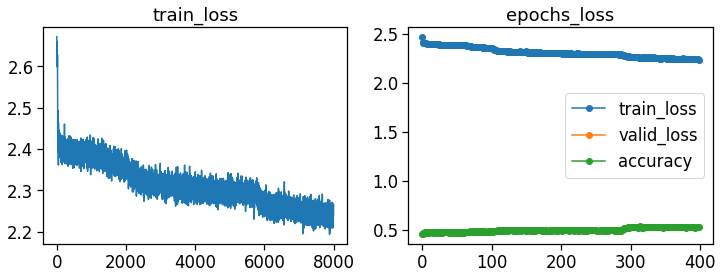

In [81]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss[1:],'-o',label="train_loss")
plt.plot(valid_epochs_loss[1:],'-o',label="valid_loss")
plt.plot(accuracy_list[1:],'-o',label="accuracy")
plt.title("epochs_loss")
plt.legend()
plt.show()

In [82]:
from model.attention.SelfAttention import ScaledDotProductAttention
import torch

input=torch.randn(50,49,512)
sa = ScaledDotProductAttention(d_model=16, d_k=140, d_v=140, h=8)
output=sa(input,input,input)
print(output.shape)

torch.Size([50, 49, 512])
